<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-+-Constants" data-toc-modified-id="Imports-+-Constants-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports + Constants</a></span></li><li><span><a href="#Load-Incountry-Folds" data-toc-modified-id="Load-Incountry-Folds-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Incountry Folds</a></span></li><li><span><a href="#Helper-methods" data-toc-modified-id="Helper-methods-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Helper methods</a></span></li><li><span><a href="#LSMSDeltaIncountry" data-toc-modified-id="LSMSDeltaIncountry-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>LSMSDeltaIncountry</a></span><ul class="toc-item"><li><span><a href="#Load-saved-preds-+-features" data-toc-modified-id="Load-saved-preds-+-features-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Load saved preds + features</a></span></li><li><span><a href="#PCA-&amp;-t-SNE-features" data-toc-modified-id="PCA-&amp;-t-SNE-features-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>PCA &amp; t-SNE features</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Fine-Tune-Final-Layer-with-Cross-Validation" data-toc-modified-id="Fine-Tune-Final-Layer-with-Cross-Validation-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Fine Tune Final Layer with Cross-Validation</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Effect-of-household-size" data-toc-modified-id="Effect-of-household-size-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Effect of household size</a></span></li><li><span><a href="#Visualize-best-and-worst-predictions" data-toc-modified-id="Visualize-best-and-worst-predictions-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Visualize best and worst predictions</a></span></li></ul></li><li><span><a href="#LSMSIndexOfDeltaIncountry" data-toc-modified-id="LSMSIndexOfDeltaIncountry-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>LSMSIndexOfDeltaIncountry</a></span><ul class="toc-item"><li><span><a href="#Load-saved-preds-+-features" data-toc-modified-id="Load-saved-preds-+-features-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Load saved preds + features</a></span></li><li><span><a href="#PCA-&amp;-t-SNE-features" data-toc-modified-id="PCA-&amp;-t-SNE-features-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>PCA &amp; t-SNE features</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Fine-Tune-Final-Layer-with-Cross-Validation" data-toc-modified-id="Fine-Tune-Final-Layer-with-Cross-Validation-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Fine Tune Final Layer with Cross-Validation</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#Effect-of-household-size" data-toc-modified-id="Effect-of-household-size-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Effect of household size</a></span></li><li><span><a href="#Visualize-best-and-worst-predictions" data-toc-modified-id="Visualize-best-and-worst-predictions-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Visualize best and worst predictions</a></span></li><li><span><a href="#Variation-by-geolevel" data-toc-modified-id="Variation-by-geolevel-5.8"><span class="toc-item-num">5.8&nbsp;&nbsp;</span>Variation by geolevel</a></span></li></ul></li></ul></div>

# Imports + Constants

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
!pip install seaborn

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

sys.path.append('../')
from batchers import batcher, dataset_constants
from models.linear_model import train_linear_logo
from utils.analysis import evaluate_df, calc_score
from utils.general import load_npz, colordisplay
from utils.geo_plot import plot_locs
from utils.plot import plot_image_by_band

In [2]:
LOGS_ROOT_DIR = './logs/'
FOLDS = ['A', 'B', 'C', 'D', 'E']
BAND_ORDER = ['BLUE', 'GREEN', 'RED', 'SWIR1', 'SWIR2', 'TEMP1', 'NIR', 'NIGHTLIGHTS']
LSMS_COUNTRIES = dataset_constants.LSMS_COUNTRIES

# Load Incountry Folds

In [5]:
# load lsmsdelta_pairs.csv
delta_pairs_df = pd.read_csv('../data/lsmsdelta_pairs.csv', index_col=False, float_precision='high')
delta_pairs_df.rename({
    'x': 'households',
    'index_diff': 'indexofdelta',
    'index': 'deltaofindex',
    'year.x': 'year1',
    'year.y': 'year2'
}, axis=1, inplace=True)
for col in ['lat', 'lon', 'deltaofindex', 'indexofdelta']:
    delta_pairs_df[col] = delta_pairs_df[col].astype(np.float32)
for col in ['year1', 'year2']:
    delta_pairs_df[col] = delta_pairs_df[col].astype(np.int32)
with pd.option_context('display.max_rows', 4):
    display(delta_pairs_df)

country_labels = delta_pairs_df['country'].map(LSMS_COUNTRIES.index).values
country_indices = {
    country: np.flatnonzero(delta_pairs_df['country'] == country)
    for country in LSMS_COUNTRIES
}
households = delta_pairs_df['households'].values

with open('../data/lsms_incountry_folds.pkl', 'rb') as f:
    incountry_folds = pickle.load(f)
npairs = len(delta_pairs_df)
incountry_group_labels = np.zeros(npairs, dtype=np.int32)
incountry_train_masks = {}  # fold => mask (un-augmented)
for i, f in enumerate(FOLDS):
    fold_mask = delta_pairs_df[['tfrecords_index.x', 'tfrecords_index.y']].isin(incountry_folds[f]['test']).values
    assert np.all(fold_mask[:, 0] == fold_mask[:, 1])
    fold_mask = fold_mask[:, 0]
    incountry_group_labels[fold_mask] = i

    fold_mask = delta_pairs_df[['tfrecords_index.x', 'tfrecords_index.y']].isin(incountry_folds[f]['train']).values
    assert np.all(fold_mask[:, 0] == fold_mask[:, 1])
    incountry_train_masks[f] = np.array(fold_mask[:, 0])  # make a copy

,lat,lon,year1,country,year2,deltaofindex,indexofdelta,geolev1,geolev2,households,tfrecords_index.x,tfrecords_index.y
0,-0.292248,31.478722,2005,uganda,2009,-0.369128,-1.782208,UGA.53,UGA,8,2574,2694
1,-0.292248,31.478722,2009,uganda,2013,-0.047140,-0.119516,UGA.53,UGA,8,2694,2941
...,...,...,...,...,...,...,...,...,...,...,...,...
1537,9.917938,11.689417,2010,nigeria,2015,0.700611,0.777255,NGA.16,NGA,1,1145,1626
1538,9.991906,37.692554,2011,ethiopia,2015,0.072652,0.049075,ETH.3,ETH,9,120,449


In [6]:
# inclusive ranges
forward_range = (0, npairs - 1)
backward_range = (npairs, 2 * npairs - 1)
directional_range = (0, 2 * npairs - 1)
zero_range = (2 * npairs, 4 * npairs - 1)

named_ranges = [
    ('forward', forward_range),
    ('backward', backward_range),
    ('bi-directional', directional_range)
]

In [7]:
locs = delta_pairs_df[['lat', 'lon']].values
labels_doi = delta_pairs_df['deltaofindex'].values
labels_iod = delta_pairs_df['indexofdelta'].values
years1 = delta_pairs_df['year1'].values
years2 = delta_pairs_df['year2'].values
weights = delta_pairs_df['households'].values
weights = weights * len(weights) / np.sum(weights)

In [8]:
locs_aug = np.tile(locs, (4, 1))
labels_doi_aug = np.concatenate([labels_doi, -labels_doi, np.zeros_like(labels_doi), np.zeros_like(labels_doi)])
labels_iod_aug = np.concatenate([labels_iod, -labels_iod, np.zeros_like(labels_iod), np.zeros_like(labels_iod)])
years1_aug = np.concatenate([years1, years2, years1, years2])
years2_aug = np.concatenate([years2, years1, years1, years2])
weights_aug = np.tile(weights, 4)

country_labels_aug = np.tile(country_labels, 4)
incountry_group_labels_aug = np.tile(incountry_group_labels, 4)
country_indices_aug = {
    country: np.tile(indices, 4)
    for country, indices in country_indices.items()
}

# Helper methods

In [9]:
def load_test_preds(npzs, labels_aug, bands_list):
    preds_df = pd.DataFrame(data={
        'label': labels_aug,
        'fold': np.asarray(FOLDS)[incountry_group_labels_aug],
        'country': np.asarray(LSMS_COUNTRIES)[country_labels_aug],
        'lat': locs_aug[:, 0],
        'lon': locs_aug[:, 1],
        'year1': years1_aug,
        'year2': years2_aug,
        'weight': weights_aug
    })

    for bands in bands_list:
        test_preds = np.zeros(npairs * 4)
        for i, f in enumerate(FOLDS):
            test_mask = (incountry_group_labels_aug == i)
            if len(npzs[(bands, f)]['preds'].shape) > 1:
                test_preds[test_mask] = npzs[(bands, f)]['preds'][test_mask, 0]
            else:
                test_preds[test_mask] = npzs[(bands, f)]['preds'][test_mask]

        col_name = 'preds_' + bands
        preds_df[col_name] = test_preds

    return preds_df

In [10]:
def print_regression_results_by_range(preds_df, forward_range, backward_range, zero_range, weighted=False):
    '''
    Args
    - preds_df: pd.DataFrame, columns ['preds_*', 'label']
    - *_range: tuple (start_index, end_index), inclusive
    - weighted: bool, if true then preds_df must have 'weights' column
    '''
    cols = [col for col in preds_df.columns if 'pred' in col]
    weights_col = 'weight' if weighted else None

    print('overall test results')
    colordisplay(evaluate_df(preds_df, cols, weights_col=weights_col))

    print('overall test results, only forward prediction')
    colordisplay(evaluate_df(preds_df.loc[slice(*forward_range), :], cols, weights_col=weights_col))

    print('overall test results, only backward prediction')
    colordisplay(evaluate_df(preds_df.loc[slice(*backward_range), :], cols, weights_col=weights_col))

    print('overall test results, only zero prediction')
    subset_df = preds_df.loc[slice(*zero_range), :]
    weights = subset_df['weight'] if weighted else None
    mses = [calc_score(labels=subset_df['label'],
                        preds=subset_df[col],
                        metric='mse', weights=weights)
            for col in cols]
    colordisplay(pd.Series(mses, index=cols).to_frame())

In [11]:
def scatterplot_by_country(preds_df, col, named_ranges):
    '''
    Args
    - preds_df: pd.DataFrame, columns ['label', 'country']
    - col: str, name of model preds column in preds_df
    - named_ranges: list of (range_name, (start_index, end_index)), ranges are inclusive
    '''
    ncols = len(named_ranges)
    fig, axs = plt.subplots(1, ncols, sharey=True, figsize=[3*ncols + 1.5, 4])
    if ncols == 1:
        axs = [axs]
    for ax, (name, range) in zip(axs, named_ranges):
        sns.scatterplot(data=preds_df.loc[slice(*range), ['label', col, 'country']],
                        ax=ax, x='label', y=col, hue='country')
        ax.set_title(name + ' deltas')
        ax.grid(True)
        ax.set_aspect('equal')
        (bot, top) = ax.get_ylim()
        bot = max(bot, -2.5) - 0.2
        top = min(top, 2.5) + 0.2
        ax.set_ylim(bot, top)

    for ax in axs[:-1]:
        ax.get_legend().remove()
    axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

In [12]:
def r2_per_band(preds_df, named_ranges, by, show_first_df=False, weighted=False):
    '''
    Args
    - test_preds_df: pd.DataFrame,
        - columns ['label', 'country', 'fold', 'year1', 'year2', 'preds_*']
    - named_ranges: list of (range_name, (start_index, end_index)), ranges are inclusive
    - by: str or list of str, from ['country', 'fold', 'year1', 'year2']
    - show_first_df: bool
    - weighted: bool
    '''
    if isinstance(by, str):
        by = [by]
    cols = [col for col in preds_df.columns if 'pred' in col]
    weights_col = 'weight' if weighted else None

    ncols = len(named_ranges)
    width = 3 * ncols + 0.5 * len(by) + 0.5
    fig, axs = plt.subplots(1, ncols, sharey=True, figsize=[width, 4])
    if ncols == 1:
        axs = [axs]
    for i, (name, range) in enumerate(named_ranges):
        results_df = (preds_df.loc[slice(*range), :]
                              .groupby(by)
                              .apply(evaluate_df, cols=cols, weights_col=weights_col))

        if show_first_df and i == 0:
            colordisplay(results_df)

        results_df = results_df['r2'].unstack(by)
        results_df['avg'] = results_df.mean(axis=1)

        ax = axs[i]
        results_df.plot.bar(ax=ax, grid=True, width=0.7, legend=False)
        ax.set_ylabel('$r^2$')
        ax.set_title('test $r^2$ ' + name)
        ax.set_ylim(0, 0.5)
    axs[-1].legend(title=by, loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.show()

In [13]:
def run_ridgecv_incountry(npzs, models_dict, base_dir, bands, labels, locs,
                          years1, years2, group_labels, weights=None):
    '''
    For every fold F (the test fold):
      1. uses leave-one-fold-out CV on all other folds
         to tune ridge model alpha parameter
      2. using best alpha, trains ridge model on all folds except F
      3. runs trained ridge model on F
    Saves predictions for each fold on test.

    Args
    - npzs: dict, (bands, fold) => npz
    - models_dict: dict, (bands, fold) => directory name
    - base_dir: str, path to dir
    - bands: str
    - labels: np.array, shape [N]
    - locs: np.array, shape [N, 2]
    - year1: np.array, shape [N]
    - year2: np.array, shape [N]
    - group_labels: np.array, shape [N]
    - weights: np.array, shape [N]
    '''
    test_preds = np.zeros(len(labels), dtype=np.float32)
    do_plot = True

    ridge_weights = {}

    for i, f in enumerate(FOLDS):
        print('Fold:', f)
        model_dir = models_dict[(bands, f)]
        features = npzs[(bands, f)]['features']

        group_labels_cv = np.array(group_labels)  # make a copy
        aug_labels = group_labels_cv[npairs:]
        aug_labels[aug_labels != i] = -1

        fold_mask = (group_labels == i)
        test_preds[fold_mask], coefs, intercept = train_linear_logo(
            features=features,
            labels=labels,
            group_labels=group_labels_cv,
            cv_groups=[x for x in range(5) if x != i],
            test_groups=[i],
            weights=weights,
            plot=do_plot,
            group_names=FOLDS,
            return_weights=True)
        ridge_weights[model_dir + '_w'] = coefs
        ridge_weights[model_dir + '_b'] = np.asarray([intercept])
        do_plot = False

    # save preds on the test set
    log_dir = os.path.join(base_dir, f'lsmsdelta_{bands}')
    os.makedirs(log_dir, exist_ok=True)
    save_dict = dict(test_preds=test_preds, locs=locs, labels=labels,
                     years1=years1, years2=years2)
    if weights is not None:
        save_dict['weights'] = weights
    npz_path = os.path.join(log_dir, 'test_preds.npz')
    np.savez_compressed(npz_path, **save_dict)
    print('saving preds to:', npz_path)

    # save model weights
    weights_npz_path = os.path.join(log_dir, 'ridge_weights.npz')
    np.savez_compressed(weights_npz_path, **ridge_weights)
    print('saving weights to:', weights_npz_path)

In [14]:
def run_ridgecv_incountry_concat(npzs, models_dict, base_dir, bands_list, labels, locs,
                                 years1, years2, group_labels, weights=None):
    '''
    For every fold F (the test fold):
      1. uses leave-one-fold-out CV on all other folds
         to tune ridge model alpha parameter
      2. using best alpha, trains ridge model on all folds except F
      3. runs trained ridge model on F
    Saves predictions for each fold on test.

    Args
    - npzs: dict, (bands, fold) => npz
    - models_dict: dict, (bands, fold) => directory name
    - base_dir: str, path to dir
    - bands_list: list of str
    - labels: np.array, shape [N]
    - locs: np.array, shape [N, 2]
    - year1: np.array, shape [N]
    - year2: np.array, shape [N]
    - group_labels: np.array, shape [N]
    - weights: np.array, shape [N]
    '''
    test_preds = np.zeros(len(labels), dtype=np.float32)
    do_plot = True

    ridge_weights = {}

    for i, f in enumerate(FOLDS):
        print('Fold:', f)
        features = np.concatenate([
            npzs[(bands, f)]['features'] for bands in bands_list
        ], axis=1)

        group_labels_cv = np.array(group_labels)  # make a copy
        aug_labels = group_labels_cv[npairs:]
        aug_labels[aug_labels != i] = -1

        fold_mask = (group_labels == i)
        test_preds[fold_mask], coefs, intercept = train_linear_logo(
            features=features,
            labels=labels,
            group_labels=group_labels_cv,
            cv_groups=[x for x in range(5) if x != i],
            test_groups=[i],
            weights=weights,
            plot=do_plot,
            group_names=FOLDS,
            return_weights=True)
        ridge_weights[f + '_w'] = coefs
        ridge_weights[f + '_b'] = np.asarray([intercept])
        do_plot = False

    name = ''.join(bands_list) + '_concat'

    # save preds on the test set
    log_dir = os.path.join(base_dir, f'lsmsdelta_{name}')
    os.makedirs(log_dir, exist_ok=True)
    save_dict = dict(test_preds=test_preds, locs=locs, labels=labels,
                     years1=years1, years2=years2)
    if weights is not None:
        save_dict['weights'] = weights
    npz_path = os.path.join(log_dir, 'test_preds.npz')
    np.savez_compressed(npz_path, **save_dict)
    print('saving preds to:', npz_path)

    # save model weights
    weights_npz_path = os.path.join(log_dir, 'ridge_weights.npz')
    np.savez_compressed(weights_npz_path, **ridge_weights)
    print('saving weights to:', weights_npz_path)

In [15]:
def load_cv_test_preds(base_dir, bands_list, folds, countries, check=None):
    bands = bands_list[0]
    npz_path = os.path.join(base_dir, f'lsmsdelta_{bands}', 'test_preds.npz')
    npz = load_npz(npz_path, check=check)

    preds_df = pd.DataFrame(data={
        'label': npz['labels'],
        'fold': folds,
        'country': countries,
        'lat': npz['locs'][:, 0],
        'lon': npz['locs'][:, 1],
        'year1': npz['years1'],
        'year2': npz['years2'],
    })
    if 'weights' in npz:
        preds_df['weight'] = npz['weights']

    check_keys = ['labels', 'locs', 'years1', 'years2']
    if 'weights' in npz:
        check_keys.append('weights')
    check = {k: npz[k] for k in check_keys}
    
    for bands in bands_list:
        npz_path = os.path.join(base_dir, f'lsmsdelta_{bands}', 'test_preds.npz')
        npz = load_npz(npz_path, check=check)

        col_name = 'preds_' + bands
        preds_df[col_name] = npz['test_preds']

    return preds_df

In [16]:
def get_images(tfrecord_paths):
    '''
    Args
    - tfrecord_paths: list of str, length N <= 32, paths of TFRecord files

    Returns: np.array, shape [N, 224, 224, 8], type float32
    '''
    lsms_batcher = batcher.Batcher(
        tfrecord_files=tfrecord_paths,
        dataset='LSMS',
        batch_size=32,
        ls_bands='ms',
        nl_band='merge',
        label_name='wealthpooled',
        shuffle=False,
        augment=False,
        negatives='zero',
        normalize=True)
    init_iter, batch_op = lsms_batcher.get_batch()
    with tf.Session() as sess:
        sess.run(init_iter)
        images = sess.run(batch_op['images'])
    return images

In [17]:
def plot_images_by_delta(images1, images2, order, labels_col, preds_col, df):
    '''
    Args
    - images1, images2: np.array, shape [K, 224, 224, 8]
    - order: str, one of ['highest', 'lowest']
    - df: pd.DataFrame, rows are sorted by some metric in the given order
        - columns: 'lat', 'lon', 'country', 'year1', 'year2', 'households', 'country', labels_col, preds_col
    '''
    cols = ['lat', 'lon', 'year1', 'year2', 'households', 'country'] + [labels_col, preds_col]
    for k in range(len(images1)):
        lat, lon, y1, y2, h, country, label, pred = df.iloc[k][cols]
        perc_error = (pred - label) * 100 / label

        print(f'{k+1}-th {order}')
        print(f'label={label:.06f}, pred={pred:.06f}, % error={perc_error:.2f}')
        print(f'loc = {country} ({lat:.06f}, {lon:.06f}), {h:d} households, {y1} to {y2}')
        for img, y in [(images1[k], y1), (images2[k], y2)]:
            band_order = list(BAND_ORDER)  # make a copy
            band_order[-1] = 'DMSP' if y < 2012 else 'VIIRS'
            plot_image_by_band(img, band_order, nrows=1, title=None, rgb='merge')

In [18]:
def plot_projection(features, labels=None, country_indices=None, pca_dim=30, proj='pca',
                    standardize=True, ax=None, cbar_name=None, title=None):
    '''
    Args
    - features: np.array, shape [N, feature_dim]
    - labels: np.array, shape [N]
    - country_indices: dict, country (str) => np.array, shape [num_per_country]
    - pca_dim: int
    - proj: str, one of ['pca', 'tsne']
    - standardize: bool
    - ax: matplotlib.axes.Axes
    - cbar_name: str, label for colorbar
    - title: str, title for axes
    '''
    X = np.array(features, copy=True)  # make a copy
    if standardize:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    if (proj != 'pca') and (X.shape[1] > pca_dim):
        pca = PCA(n_components=pca_dim, whiten=False)
        X = pca.fit_transform(X)

    if proj == 'pca':
        pca = PCA(n_components=2, whiten=False)
        X = pca.fit_transform(X)
    elif proj == 'tsne':
        tsne = TSNE(n_components=2)
        print('running TSNE...', end='')
        start = time.time()
        X = tsne.fit_transform(X=X)
        elapsed = time.time() - start
        print(f'TSNE finished in {elapsed:.1f} seconds.')

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    else:
        fig = ax.get_figure()
    ax.set_aspect('equal')
    ax.set_title(title)

    if labels is not None:
        im = ax.scatter(X[:, 0], X[:, 1], c=labels, s=2)
        if cbar_name is not None:
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label(cbar_name)
    elif country_indices is not None:
        for country, idxs in country_indices.items():
            ax.scatter(X[idxs, 0], X[idxs, 1], label=country, s=2)

# LSMSDeltaIncountry

## Load saved preds + features

In [19]:
BASE_DIR = os.path.join(LOGS_ROOT_DIR, 'LSMSDeltaIncountry')
MODELS = {
    ('ms', 'A'): 'LSMSDeltaIncountryA_bidir_18preact_ms_random_b64_fc001_conv001_lr0001',
    ('ms', 'B'): 'LSMSDeltaIncountryB_bidir_18preact_ms_random_b64_fc01_conv01_lr0001',
    ('ms', 'C'): 'LSMSDeltaIncountryC_bidir_18preact_ms_random_b64_fc01_conv01_lr0001',
    ('ms', 'D'): 'LSMSDeltaIncountryD_bidir_18preact_ms_random_b64_fc1_conv1_lr0001',
    ('ms', 'E'): 'LSMSDeltaIncountryE_bidir_18preact_ms_random_b64_fc001_conv001_lr0001',
    ('msnl', 'A'): 'LSMSDeltaIncountryA_bidir_18preact_msnl_random_b64_fc001_conv001_lr0001',
    ('msnl', 'B'): 'LSMSDeltaIncountryB_bidir_18preact_msnl_random_b64_fc01_conv01_lr0001',
    ('msnl', 'C'): 'LSMSDeltaIncountryC_bidir_18preact_msnl_random_b64_fc001_conv001_lr0001',
    ('msnl', 'D'): 'LSMSDeltaIncountryD_bidir_18preact_msnl_random_b64_fc1_conv1_lr0001',
    ('msnl', 'E'): 'LSMSDeltaIncountryE_bidir_18preact_msnl_random_b64_fc1_conv1_lr0001',
    ('nl', 'A'): 'LSMSDeltaIncountryA_bidir_18preact_nl_random_b64_fc001_conv001_lr0001',
    ('nl', 'B'): 'LSMSDeltaIncountryB_bidir_18preact_nl_random_b64_fc01_conv01_lr0001',
    ('nl', 'C'): 'LSMSDeltaIncountryC_bidir_18preact_nl_random_b64_fc001_conv001_lr0001',
    ('nl', 'D'): 'LSMSDeltaIncountryD_bidir_18preact_nl_random_b64_fc01_conv01_lr0001',
    ('nl', 'E'): 'LSMSDeltaIncountryE_bidir_18preact_nl_random_b64_fc001_conv001_lr0001',
}

In [20]:
npzs = {
    model: load_npz(os.path.join(BASE_DIR, model_dir, 'features.npz'),
                    check=dict(locs=locs_aug, labels=labels_doi_aug, years1=years1_aug,
                               years2=years2_aug, weights=weights_aug))
    for model, model_dir in MODELS.items()
}

FileNotFoundError: [Errno 2] No such file or directory: './logs/LSMSDeltaIncountry\\LSMSDeltaIncountryA_bidir_18preact_ms_random_b64_fc001_conv001_lr0001\\features.npz'

In [21]:
test_preds_df = load_test_preds(npzs, labels_aug=labels_doi_aug, bands_list=['ms', 'msnl', 'nl'])
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

NameError: name 'npzs' is not defined

## PCA & t-SNE features

In [22]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        labels=npz['labels'][:npairs],
        proj='pca',
        ax=ax,
        cbar_name=None if i < 4 else 'label',
        title=f'Fold {f}')
fig.suptitle('PCA features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [23]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        country_indices=country_indices,
        proj='pca',
        ax=ax,
        title=f'Fold {f}')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('PCA features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [24]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        labels=npz['labels'][:npairs],
        proj='tsne',
        ax=ax,
        cbar_name=None if i < 4 else 'label',
        title=f'Fold {f}')
fig.suptitle('T-SNE features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [25]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        country_indices=country_indices,
        proj='tsne',
        ax=ax,
        title=f'Fold {f}')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('T-SNE features', y=1.02)
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

## Evaluate

In [26]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range)

NameError: name 'test_preds_df' is not defined

In [27]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range,
                                  weighted=True)

NameError: name 'test_preds_df' is not defined

In [28]:
scatterplot_by_country(test_preds_df, col='preds_ms', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [29]:
scatterplot_by_country(test_preds_df, col='preds_ms', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [30]:
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by=['country', 'year1', 'year2'], weighted=True)

NameError: name 'test_preds_df' is not defined

In [31]:
r2_per_band(test_preds_df, named_ranges, by='fold', weighted=True)
r2_per_band(test_preds_df, named_ranges, by='country', weighted=True)

NameError: name 'test_preds_df' is not defined

## Fine Tune Final Layer with Cross-Validation

In [32]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='ms',
    labels=labels_doi_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [33]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='msnl',
    labels=labels_doi_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [34]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='nl',
    labels=labels_doi_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [35]:
run_ridgecv_incountry_concat(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands_list=['ms', 'nl'],
    labels=labels_doi_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [36]:
test_preds_df = load_cv_test_preds(
    base_dir=BASE_DIR,
    bands_list=['ms', 'msnl', 'nl', 'msnl_concat'],
    folds=test_preds_df['fold'].values,
    countries=test_preds_df['country'].values,
    check=dict(labels=labels_doi_aug, locs=locs_aug, weights=weights_aug, years1=years1_aug, years2=years2_aug))

NameError: name 'test_preds_df' is not defined

In [37]:
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

NameError: name 'test_preds_df' is not defined

In [38]:
forward_preds_df = test_preds_df.loc[slice(*forward_range)]
csv_path = os.path.join('../model_analysis', 'lsmsdelta_preds_incountry.csv')
# forward_preds_df.to_csv(csv_path, index=False)

NameError: name 'test_preds_df' is not defined

## Evaluate

In [39]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range)

NameError: name 'test_preds_df' is not defined

In [40]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range,
                                  weighted=True)

NameError: name 'test_preds_df' is not defined

In [41]:
scatterplot_by_country(test_preds_df, col='preds_msnl', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [42]:
r2_per_band(test_preds_df, named_ranges, by='fold', show_first_df=True, weighted=True)
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by=['country', 'year1', 'year2'], show_first_df=True, weighted=True)
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by='country', show_first_df=True, weighted=True)

NameError: name 'test_preds_df' is not defined

In [43]:
results_bycountryfold_df = (
    forward_preds_df
    .groupby(['country', 'fold', 'year1', 'year2'])
    .apply(evaluate_df, cols=['preds_ms', 'preds_msnl', 'preds_nl']))
colordisplay(results_bycountryfold_df)

NameError: name 'forward_preds_df' is not defined

## Effect of household size

In [44]:
forward_df = pd.merge(forward_preds_df, delta_pairs_df, on=['lat', 'lon', 'country', 'year1', 'year2'])
forward_df['residual'] = forward_df['label'] - forward_df['preds_ms']
ax = forward_df.plot(kind='scatter', x='households', y='residual')
ax.grid(True)

NameError: name 'forward_preds_df' is not defined

In [45]:
R2s = []
r2s = []
mses = []
hs = sorted(forward_df['households'].unique())
for i, h in enumerate(hs):
    selection = forward_df.loc[forward_df['households'] >= h, :]
    R2 = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='R2')
    r2 = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='r2')
    mse = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='mse')
    R2s.append(R2)
    r2s.append(r2)
    mses.append(mse)

    if i % 4 == 0:
        fig, ax = plt.subplots(1, 1)
        ax.scatter(selection['label'], selection['preds_ms'], s=2, label=f'$r^2$={r2:.3f}')
        ax.set(xlabel='label', ylabel='pred', title=f'households $\geq$ {h:.2f}')
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        plt.show()
        plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(hs, r2s, label='$r^2$')
ax.plot(hs, mses, label='mse')
ax.legend()
ax.grid(True)
ax.set(xlabel=r'# households $\geq x$', ylabel='score')
plt.show()

NameError: name 'forward_df' is not defined

In [46]:
display(forward_df.iloc[:5])
print(len(forward_df))
print(forward_df['households'].min())

NameError: name 'forward_df' is not defined

In [47]:
min_hs = np.arange(1, 14, 2)
min_absdeltas = np.arange(0, 2, 0.25)

r2s = np.zeros([len(min_hs), len(min_absdeltas)])

for i, min_h in enumerate(min_hs):
    for j, min_absdelta in enumerate(min_absdeltas):
        mask = (forward_df['households'] >= min_h) & (forward_df['deltaofindex'].abs() >= min_absdelta)
        if (min_h == 1) and (min_absdelta == 0):
            assert mask.all()
        tmp = forward_df.loc[mask, :]
        if len(tmp) == 0: continue
        r2 = calc_score(labels=tmp['label'], preds=tmp['preds_ms'], weights=tmp['weight'], metric='r2')
        r2s[i, j] = r2

NameError: name 'forward_df' is not defined

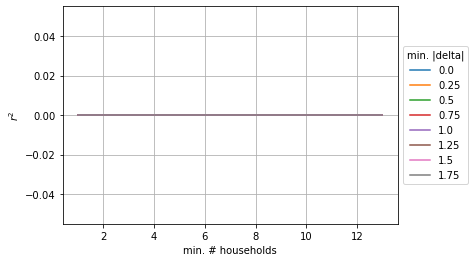

In [48]:
fig, ax = plt.subplots(1, 1)
for j, min_absdelta in enumerate(min_absdeltas):
    ax.plot(min_hs, r2s[:, j], label=str(min_absdelta))
ax.set(xlabel='min. # households', ylabel='$r^2$')
ax.legend(title='min. |delta|', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

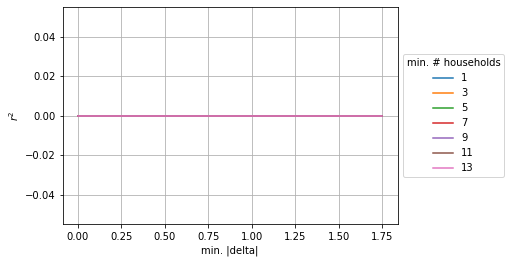

In [49]:
fig, ax = plt.subplots(1, 1)
for i, min_h in enumerate(min_hs):
    ax.plot(min_absdeltas, r2s[i], label=str(min_h))
ax.set(xlabel='min. |delta|', ylabel='$r^2$')
ax.legend(title='min. # households', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

## Visualize best and worst predictions

Measure performance on each location as % error, relative to ground truth.

In [50]:
# ONLY RUN THIS SECTION IF USING SAVED CSVS
csv_path = os.path.join('../model_analysis', 'lsmsdelta_preds_incountry.csv')
forward_preds_df = pd.read_csv(csv_path)
forward_preds_df['lat'] = np.float32(forward_preds_df['lat'])
forward_preds_df['lon'] = np.float32(forward_preds_df['lon'])

forward_df = pd.merge(forward_preds_df, delta_pairs_df, on=['lat', 'lon', 'country', 'year1', 'year2'])
forward_df['residual'] = forward_df['label'] - forward_df['preds_msnl']

FileNotFoundError: [Errno 2] No such file or directory: '../model_analysis\\lsmsdelta_preds_incountry.csv'

In [51]:
tfrecord_paths = np.asarray(batcher.get_lsms_tfrecord_paths(dataset_constants.SURVEY_NAMES['LSMS']))
K = 5

AssertionError: 

In [52]:
print('Largest pred:', forward_df['preds_msnl'].abs().max())

top_k = forward_df['preds_msnl'].abs().sort_values().index[-1:-K-1:-1]
display(forward_df.loc[top_k])

paired_indices = forward_df.loc[top_k, ['tfrecords_index.x', 'tfrecords_index.y']].values
images1 = get_images(tfrecord_paths[paired_indices[:, 0]])
images2 = get_images(tfrecord_paths[paired_indices[:, 1]])

NameError: name 'forward_df' is not defined

In [54]:
plot_images_by_delta(
    images1, images2,
    order='largest abs. pred (delta-of-index)',
    labels_col='deltaofindex',
    preds_col='preds_msnl',
    df=forward_df.loc[top_k])

NameError: name 'images1' is not defined

In [55]:
perc_error = (forward_df['preds_msnl'] - forward_df['label']) / forward_df['label']
print('lowest % error:', perc_error.abs().min() * 100)

best_k = perc_error.abs().sort_values().index[:K]
display(forward_df.loc[top_k])

paired_indices = forward_df.loc[best_k, ['tfrecords_index.x', 'tfrecords_index.y']].values
images1 = get_images(tfrecord_paths[paired_indices[:, 0]])
images2 = get_images(tfrecord_paths[paired_indices[:, 1]])

NameError: name 'forward_df' is not defined

In [56]:
plot_images_by_delta(
    images1, images2,
    order='lowest % error (delta-of-index)',
    labels_col='deltaofindex',
    preds_col='preds_msnl',
    df=forward_df.loc[best_k])

NameError: name 'images1' is not defined

# LSMSIndexOfDeltaIncountry

## Load saved preds + features

In [57]:
BASE_DIR = os.path.join(LOGS_ROOT_DIR, 'LSMSIndexOfDeltaIncountry')
MODELS = {
    ('ms', 'A'): 'LSMSIndexOfDeltaIncountryA_bidir_18preact_ms_random_b64_fc1_conv1_lr0001',
    ('ms', 'B'): 'LSMSIndexOfDeltaIncountryB_bidir_18preact_ms_random_b64_fc1_conv1_lr0001',
    ('ms', 'C'): 'LSMSIndexOfDeltaIncountryC_bidir_18preact_ms_random_b64_fc1_conv1_lr0001',
    ('ms', 'D'): 'LSMSIndexOfDeltaIncountryD_bidir_18preact_ms_random_b64_fc1_conv1_lr0001',
    ('ms', 'E'): 'LSMSIndexOfDeltaIncountryE_bidir_18preact_ms_random_b64_fc01_conv01_lr0001',
    ('msnl', 'A'): 'LSMSIndexOfDeltaIncountryA_bidir_18preact_msnl_random_b64_fc001_conv001_lr0001',
    ('msnl', 'B'): 'LSMSIndexOfDeltaIncountryB_bidir_18preact_msnl_random_b64_fc01_conv01_lr0001',
    ('msnl', 'C'): 'LSMSIndexOfDeltaIncountryC_bidir_18preact_msnl_random_b64_fc1_conv1_lr0001',
    ('msnl', 'D'): 'LSMSIndexOfDeltaIncountryD_bidir_18preact_msnl_random_b64_fc1_conv1_lr0001',
    ('msnl', 'E'): 'LSMSIndexOfDeltaIncountryE_bidir_18preact_msnl_random_b64_fc1_conv1_lr0001',
    ('nl', 'A'): 'LSMSIndexOfDeltaIncountryA_bidir_18preact_nl_random_b64_fc001_conv001_lr0001',
    ('nl', 'B'): 'LSMSIndexOfDeltaIncountryB_bidir_18preact_nl_random_b64_fc001_conv001_lr0001',
    ('nl', 'C'): 'LSMSIndexOfDeltaIncountryC_bidir_18preact_nl_random_b64_fc01_conv01_lr0001',
    ('nl', 'D'): 'LSMSIndexOfDeltaIncountryD_bidir_18preact_nl_random_b64_fc1_conv1_lr0001',
    ('nl', 'E'): 'LSMSIndexOfDeltaIncountryE_bidir_18preact_nl_random_b64_fc01_conv01_lr0001',
}

In [58]:
npzs = {
    model: load_npz(os.path.join(BASE_DIR, model_dir, 'features.npz'),
                    check=dict(locs=locs_aug, labels=labels_iod_aug, years1=years1_aug,
                               years2=years2_aug, weights=weights_aug))
    for model, model_dir in MODELS.items()
}

FileNotFoundError: [Errno 2] No such file or directory: './logs/LSMSIndexOfDeltaIncountry\\LSMSIndexOfDeltaIncountryA_bidir_18preact_ms_random_b64_fc1_conv1_lr0001\\features.npz'

In [59]:
test_preds_df = load_test_preds(npzs, labels_aug=labels_iod_aug, bands_list=['ms', 'msnl', 'nl'])
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

NameError: name 'npzs' is not defined

## PCA & t-SNE features

In [60]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        labels=npz['labels'][:npairs],
        proj='pca',
        ax=ax,
        cbar_name=None if i < 4 else 'label',
        title=f'Fold {f}')
fig.suptitle('PCA features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [61]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        country_indices=country_indices,
        proj='pca',
        ax=ax,
        title=f'Fold {f}')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('PCA features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [62]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        labels=npz['labels'][:npairs],
        proj='tsne',
        ax=ax,
        cbar_name=None if i < 4 else 'label',
        title=f'Fold {f}')
fig.suptitle('T-SNE features')
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [63]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    plot_projection(
        features=npz['features'][:npairs],
        country_indices=country_indices,
        proj='tsne',
        ax=ax,
        title=f'Fold {f}')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('T-SNE features', y=1.02)
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

In [64]:
# forward-direction, training examples only
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(15, 4))
for i, f in enumerate(FOLDS):
    ax = axs[i]
    npz = npzs[('msnl', f)]
    country_indices_train = {
        country: np.flatnonzero(delta_pairs_df['country'].values[incountry_train_masks[f]] == country)
        for country in LSMS_COUNTRIES
    }
    plot_projection(
        features=npz['features'][:npairs][incountry_train_masks[f]],
        country_indices=country_indices_train,
        proj='tsne',
        ax=ax,
        title=f'Fold {f}')
axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.suptitle('T-SNE features', y=1.02)
fig.tight_layout()
plt.show()

NameError: name 'npzs' is not defined

## Evaluate

In [65]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range)

NameError: name 'test_preds_df' is not defined

In [66]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range,
                                  weighted=True)

NameError: name 'test_preds_df' is not defined

In [67]:
scatterplot_by_country(test_preds_df, col='preds_ms', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [68]:
scatterplot_by_country(test_preds_df, col='preds_ms', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [69]:
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by=['country', 'year1', 'year2'], weighted=True)

NameError: name 'test_preds_df' is not defined

In [70]:
r2_per_band(test_preds_df, named_ranges, by='fold', weighted=True)
r2_per_band(test_preds_df, named_ranges, by='country', weighted=True)

NameError: name 'test_preds_df' is not defined

## Fine Tune Final Layer with Cross-Validation

In [71]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='ms',
    labels=labels_iod_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [72]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='msnl',
    labels=labels_iod_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [73]:
run_ridgecv_incountry(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands='nl',
    labels=labels_iod_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [74]:
run_ridgecv_incountry_concat(
    npzs=npzs, models_dict=MODELS, base_dir=BASE_DIR,
    bands_list=['ms', 'nl'],
    labels=labels_iod_aug,
    locs=locs_aug,
    years1=years1_aug,
    years2=years2_aug,
    group_labels=incountry_group_labels_aug,
    weights=weights_aug)

NameError: name 'npzs' is not defined

In [75]:
test_preds_df = load_cv_test_preds(
    base_dir=BASE_DIR,
    bands_list=['ms', 'msnl', 'nl', 'msnl_concat'],
    folds=test_preds_df['fold'].values,
    countries=test_preds_df['country'].values,
    check=dict(labels=labels_iod_aug, locs=locs_aug, weights=weights_aug, years1=years1_aug, years2=years2_aug))

NameError: name 'test_preds_df' is not defined

In [76]:
with pd.option_context('display.max_rows', 4):
    display(test_preds_df)

NameError: name 'test_preds_df' is not defined

In [77]:
forward_preds_df = test_preds_df.loc[slice(*forward_range)]
csv_path = os.path.join('../model_analysis', 'lsms_indexofdelta_preds_incountry.csv')
# forward_preds_df.to_csv(csv_path, index=False)

NameError: name 'test_preds_df' is not defined

## Evaluate

In [78]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range)

NameError: name 'test_preds_df' is not defined

In [79]:
print_regression_results_by_range(test_preds_df, forward_range, backward_range, zero_range,
                                  weighted=True)

NameError: name 'test_preds_df' is not defined

In [80]:
scatterplot_by_country(test_preds_df, col='preds_ms', named_ranges=named_ranges)

NameError: name 'test_preds_df' is not defined

In [81]:
r2_per_band(test_preds_df, named_ranges, by='fold', show_first_df=True, weighted=True)
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by=['country', 'year1', 'year2'], show_first_df=True, weighted=True)
r2_per_band(test_preds_df, named_ranges=[('forward', forward_range)],
            by='country', show_first_df=True, weighted=True)

NameError: name 'test_preds_df' is not defined

In [82]:
results_bycountryfold_df = (
    forward_preds_df
    .groupby(['country', 'fold', 'year1', 'year2'])
    .apply(evaluate_df, cols=['preds_ms', 'preds_msnl', 'preds_nl']))
colordisplay(results_bycountryfold_df)

NameError: name 'forward_preds_df' is not defined

## Effect of household size

In [83]:
forward_df = pd.merge(forward_preds_df, delta_pairs_df, on=['lat', 'lon', 'country', 'year1', 'year2'])
forward_df['residual'] = forward_df['label'] - forward_df['preds_ms']
ax = forward_df.plot(kind='scatter', x='households', y='residual')
ax.grid(True)

NameError: name 'forward_preds_df' is not defined

In [84]:
R2s = []
r2s = []
mses = []
hs = sorted(forward_df['households'].unique())
for i, h in enumerate(hs):
    selection = forward_df.loc[forward_df['households'] >= h, :]
    R2 = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='R2')
    r2 = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='r2')
    mse = calc_score(selection['label'], selection['preds_ms'], weights=selection['weight'], metric='mse')
    R2s.append(R2)
    r2s.append(r2)
    mses.append(mse)

    if i % 4 == 0:
        fig, ax = plt.subplots(1, 1)
        ax.scatter(selection['label'], selection['preds_ms'], s=2, label=f'$r^2$={r2:.3f}')
        ax.set(xlabel='label', ylabel='pred', title=f'households $\geq$ {h:.2f}')
        ax.set_aspect('equal')
        ax.grid(True)
        ax.legend()
        plt.show()
        plt.close()

fig, ax = plt.subplots(1, 1)
ax.plot(hs, r2s, label='$r^2$')
ax.plot(hs, mses, label='mse')
ax.legend()
ax.grid(True)
ax.set(xlabel=r'# households $\geq x$', ylabel='score')
plt.show()

NameError: name 'forward_df' is not defined

In [85]:
display(forward_df.iloc[:5])
print(len(forward_df))
print(forward_df['households'].min())

NameError: name 'forward_df' is not defined

In [86]:
min_hs = np.arange(1, 14, 2)
min_absdeltas = np.arange(0, 2, 0.25)

r2s = np.zeros([len(min_hs), len(min_absdeltas)])

for i, min_h in enumerate(min_hs):
    for j, min_absdelta in enumerate(min_absdeltas):
        mask = (forward_df['households'] >= min_h) & (forward_df['indexofdelta'].abs() >= min_absdelta)
        if (min_h == 1) and (min_absdelta == 0):
            assert mask.all()
        tmp = forward_df.loc[mask, :]
        if len(tmp) == 0: continue
        r2 = calc_score(labels=tmp['label'], preds=tmp['preds_ms'], weights=tmp['weight'], metric='r2')
        r2s[i, j] = r2

NameError: name 'forward_df' is not defined

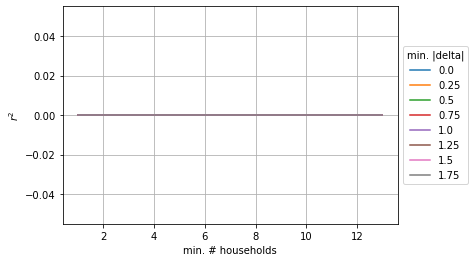

In [87]:
fig, ax = plt.subplots(1, 1)
for j, min_absdelta in enumerate(min_absdeltas):
    ax.plot(min_hs, r2s[:, j], label=str(min_absdelta))
ax.set(xlabel='min. # households', ylabel='$r^2$')
ax.legend(title='min. |delta|', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

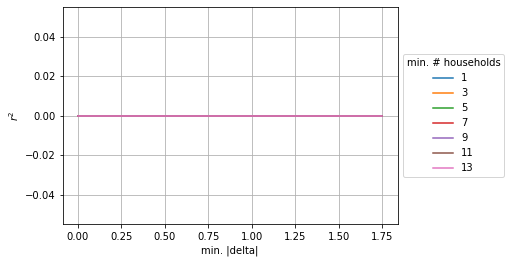

In [88]:
fig, ax = plt.subplots(1, 1)
for i, min_h in enumerate(min_hs):
    ax.plot(min_absdeltas, r2s[i], label=str(min_h))
ax.set(xlabel='min. |delta|', ylabel='$r^2$')
ax.legend(title='min. # households', loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True)

## Visualize best and worst predictions

Measure performance on each location as % error, relative to ground truth.

In [89]:
# ONLY RUN THIS SECTION IF USING SAVED CSVS
csv_path = os.path.join('../model_analysis', 'lsms_indexofdelta_preds_incountry.csv')
forward_preds_df = pd.read_csv(csv_path)
forward_preds_df['lat'] = np.float32(forward_preds_df['lat'])
forward_preds_df['lon'] = np.float32(forward_preds_df['lon'])

forward_df = pd.merge(forward_preds_df, delta_pairs_df, on=['lat', 'lon', 'country', 'year1', 'year2'])
forward_df['residual'] = forward_df['label'] - forward_df['preds_ms']

FileNotFoundError: [Errno 2] No such file or directory: '../model_analysis\\lsms_indexofdelta_preds_incountry.csv'

In [90]:
tfrecord_paths = np.asarray(batcher.get_lsms_tfrecord_paths(dataset_constants.SURVEY_NAMES['LSMS']))
K = 5

AssertionError: 

In [91]:
print('Largest pred:', forward_df['preds_ms'].abs().max())

top_k = forward_df['preds_ms'].abs().sort_values().index[-1:-K-1:-1]
display(forward_df.loc[top_k])

paired_indices = forward_df.loc[top_k, ['tfrecords_index.x', 'tfrecords_index.y']].values
images1 = get_images(tfrecord_paths[paired_indices[:, 0]])
images2 = get_images(tfrecord_paths[paired_indices[:, 1]])

NameError: name 'forward_df' is not defined

In [92]:
plot_images_by_delta(
    images1, images2,
    order='largest abs. pred (index-of-delta)',
    labels_col='indexofdelta',
    preds_col='preds_ms',
    df=forward_df.loc[top_k])

NameError: name 'images1' is not defined

In [93]:
perc_error = (forward_df['preds_ms'] - forward_df['label']) / forward_df['label']
print('lowest % error:', perc_error.abs().min() * 100)

best_k = perc_error.abs().sort_values().index[:K]
display(forward_df.loc[top_k])

paired_indices = forward_df.loc[best_k, ['tfrecords_index.x', 'tfrecords_index.y']].values
images1 = get_images(tfrecord_paths[paired_indices[:, 0]])
images2 = get_images(tfrecord_paths[paired_indices[:, 1]])

NameError: name 'forward_df' is not defined

In [94]:
plot_images_by_delta(
    images1, images2,
    order='lowest % error (index-of-delta)',
    labels_col='indexofdelta',
    preds_col='preds_ms',
    df=forward_df.loc[best_k])

NameError: name 'images1' is not defined

In [95]:
def plot_preds_by_fold_country():
    vmin = min(forward_preds_df['preds_ms'].min(), forward_preds_df['label'].min())
    vmax = max(forward_preds_df['preds_ms'].max(), forward_preds_df['label'].max())
    for c in forward_preds_df['country'].unique():
        # fig, axs = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
        fig = plt.figure(figsize=(22, 4))
        for i, f in enumerate(['A', 'B', 'C', 'D', 'E']):
            subset_df = forward_preds_df[(forward_preds_df['country'] == c) & (forward_preds_df['fold'] == f)]
            plot_locs(fig=fig, pos=(1, 5, i+1), locs=subset_df[['lat', 'lon']].values,
                      colors=subset_df['preds_ms'].values, show_cbar=(i==4),
                      title=f'fold-{f}', cbar_label='preds_ms',
                      vmin=vmin, vmax=vmax, s=10)
        fig.suptitle(f'{c} index-of-delta preds', y=1.01)

        fig = plt.figure(figsize=(22, 4))
        for i, f in enumerate(['A', 'B', 'C', 'D', 'E']):
            subset_df = forward_preds_df[(forward_preds_df['country'] == c) & (forward_preds_df['fold'] == f)]
            plot_locs(fig=fig, pos=(1, 5, i+1), locs=subset_df[['lat', 'lon']].values,
                      colors=subset_df['label'].values, show_cbar=(i==4),
                      title=f'fold-{f}', cbar_label='label',
                      vmin=vmin, vmax=vmax, s=10)
        fig.suptitle(f'{c} index-of-delta labels', y=1.01)
        plt.show()

plot_preds_by_fold_country()

NameError: name 'forward_preds_df' is not defined

## Variation by geolevel

In [96]:
stds = forward_df.groupby(['fold', 'geolev1'])[['label', 'preds_ms']].std()
display(stds)

stds_norm = stds.copy()
stds_norm['label'] /= forward_df['label'].std()
stds_norm['preds_ms'] /= forward_df['preds_ms'].std()
(stds_norm['label'] - stds_norm['preds_ms']).hist(bins=np.arange(-1.5, 1.5, 0.1))

NameError: name 'forward_df' is not defined

In [97]:
def weighted_std(x, weights):
    mean = np.average(x, weights=weights)
    var = np.average((x - mean)**2, weights=weights)
    return np.sqrt(var / (len(x) - 1))

def apply_weighted_std(df, weights_col):
    cols = list(df.columns)
    cols.remove(weights_col)
    weights = df[weights_col]
    result = {c: weighted_std(df[c], weights) for c in cols}
    return pd.Series(result)

In [98]:
stds = forward_df.groupby(['fold', 'geolev1'])[['label', 'preds_ms', 'households']].apply(apply_weighted_std, weights_col='households')
display(stds)

stds_norm = stds.copy()
stds_norm['label'] /= weighted_std(forward_df['label'], weights=forward_df['households'])
stds_norm['preds_ms'] /= weighted_std(forward_df['preds_ms'], weights=forward_df['households'])
ax = (stds_norm['label'] - stds_norm['preds_ms']).hist(bins=np.arange(-1.5, 1.5, 0.1))
ax.set_title('histogram of difference in std-devs between preds and labels')
ax.set_ylabel('count of (geolev1, fold) tuples')
ax.set_xlabel('(std-dev of preds) - (std-dev of labels)')
plt.show()

NameError: name 'forward_df' is not defined